## Convolutional Neural Network for MNIST image classficiation 

In [7]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Alternating Least Squares for Matrix Factorization

In [15]:
def coding_within_radius(X, W, H0, 
                         r=None, 
                         a1=0, #L1 regularizer
                         a2=0, #L2 regularizer
                         sub_iter=[5], 
                         stopping_grad_ratio=0.0001, 
                         nonnegativity=True,
                         subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    B = W.T @ X[:,idx]
    while (i < np.random.choice(sub_iter)):
        if_continue = np.ones(H0.shape[0])  # indexed by rows of H
        H1_old = H1.copy()
        for k in [k for k in np.arange(H0.shape[0])]:
            grad = (np.dot(A[k, :], H1[:,idx]) - B[k,:] + a1 * np.ones(len(idx))) + a2 * 2 * np.sign(H1[k,idx])
            grad_norm = np.linalg.norm(grad, 2)
            step_size = (1 / (((i + 1) ** (1)) * (A[k, k] + 1)))
            if r is not None:  # usual sparse coding without radius restriction
                d = step_size * grad_norm
                step_size = (r / max(r, d)) * step_size

            if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
                H1[k, idx] = H1[k, idx] - step_size * grad

            if nonnegativity:
                H1[k,idx] = np.maximum(H1[k,idx], np.zeros(shape=(len(idx),)))  # nonnegativity constraint

        i = i + 1
    return H1

In [14]:
def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

In [5]:
# Simulated Data and its factorization 

W0 = np.random.rand(10,5)
H0 = np.random.rand(5,20)
X0 = W0 @ H0

W, H = ALS(X=X0, 
           n_components=5, 
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 1, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

print('reconstruction error (relative) = %f' % (np.linalg.norm(X0-W@H)**2/np.linalg.norm(X0)**2))
print('Dictionary error (relative) = %f' % (np.linalg.norm(W0 - W)**2/np.linalg.norm(W0)**2))
print('Code error (relative) = %f' % (np.linalg.norm(H0-H)**2/np.linalg.norm(H0)**2))


 68%|██████▊   | 68/100 [00:00<00:00, 304.02it/s]

iteration 0, reconstruction error 9.561927
iteration 10, reconstruction error 1.534195
iteration 20, reconstruction error 1.244448
iteration 30, reconstruction error 1.121882
iteration 40, reconstruction error 1.005543
iteration 50, reconstruction error 0.902546
iteration 60, reconstruction error 0.812917
iteration 70, reconstruction error 0.723204


100%|██████████| 100/100 [00:00<00:00, 351.73it/s]

iteration 80, reconstruction error 0.635643
iteration 90, reconstruction error 0.558841
reconstruction error (relative) = 0.001474
Dictionary error (relative) = 0.815765
Code error (relative) = 20.915899


# Learn dictionary of MNIST images 

In [6]:
def display_dictionary(W, save_name=None, score=None, grid_shape=None):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=(6, 6)
    if (score is not None) and (grid_shape is None):
       figsize0=(6, 7)
    if (score is not None) and (grid_shape is not None):
       figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

In [7]:
def display_dictionary_list(W_list, label_list, save_name=None, score_list=None):
    # Make plot
    
    # outer gridspec
    nrows=1
    ncols=len(W_list)
    fig = plt.figure(figsize=(16, 5), constrained_layout=False)
    outer_grid = gridspec.GridSpec(nrows=nrows, ncols=ncols, wspace=0.1, hspace=0.05)

    
    
    # make nested gridspecs
    for i in range(1 * ncols):
        k = int(np.sqrt(W_list[i].shape[0]))
        sub_rows = int(np.sqrt(W_list[i].shape[1]))
        sub_cols = int(np.sqrt(W_list[i].shape[1]))

        idx = np.arange(W_list[i].shape[1])
        if score_list is not None:
            idx = np.argsort(score_list[i])
            idx = np.flip(idx)    
        
        inner_grid = outer_grid[i].subgridspec(sub_rows, sub_cols, wspace=0.05, hspace=0.05)

        for j in range(sub_rows*sub_cols):
            a = j // sub_cols 
            b = j % sub_cols #sub-lattice indices

            ax = fig.add_subplot(inner_grid[a, b])
            ax.imshow(W_list[i].T[idx[j]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xticks([])
            if (b>0):
                ax.set_yticks([])
            if (a < sub_rows-1):
                ax.set_xticks([])
            if (a == 0) and (b==2):
                #ax.set_title("W_nonnegativity$=$ %s \n H_nonnegativity$=$ %s" 
                #             % (str(nonnegativity_list[i][0]), str(nonnegativity_list[i][1])), y=1.2, fontsize=14) 
                ax.set_title(label_list[i], y=1.2, fontsize=14)
            if (score_list is not None) and (score_list[i] is not None):
                ax.set_xlabel('%1.2f' % score_list[i][idx[j]], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.07)
           
                
                
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    plt.savefig(save_name, bbox_inches='tight')

In [10]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

  4%|▍         | 2/50 [00:00<00:08,  5.39it/s]

iteration 0, reconstruction error 6147.554385


 24%|██▍       | 12/50 [00:01<00:03, 10.40it/s]

iteration 10, reconstruction error 1853.809629


 44%|████▍     | 22/50 [00:02<00:02, 10.27it/s]

iteration 20, reconstruction error 1490.544808


 64%|██████▍   | 32/50 [00:03<00:01, 12.28it/s]

iteration 30, reconstruction error 1360.434365


 84%|████████▍ | 42/50 [00:03<00:00, 13.11it/s]

iteration 40, reconstruction error 1292.752752


100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


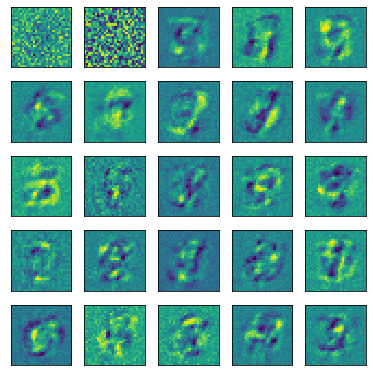

In [11]:
# Unconstrained matrix factorization and dictionary images 

idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=50, 
           subsample_ratio=1, 
           W_nonnegativity=False,
           H_nonnegativity=False,
           compute_recons_error=True)

display_dictionary(W)

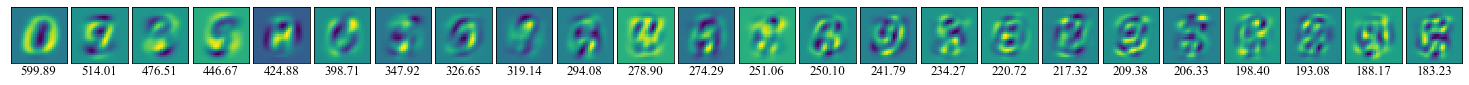

In [12]:
# PCA and dictionary images (principal components)

pca = PCA(n_components=24)
pca.fit(X)
W = pca.components_.T
s = pca.singular_values_

display_dictionary(W, score=s, save_name = "MNIST_PCA_ex1.pdf", grid_shape=[1,24])

 30%|███       | 3/10 [00:00<00:00,  8.95it/s]

iteration 0, reconstruction error 6244.520919


 30%|███       | 3/10 [00:00<00:00,  8.45it/s]

iteration 0, reconstruction error 4650.859461


 20%|██        | 2/10 [00:00<00:00, 13.25it/s]

iteration 0, reconstruction error 4672.917735


100%|██████████| 10/10 [00:00<00:00, 12.61it/s]


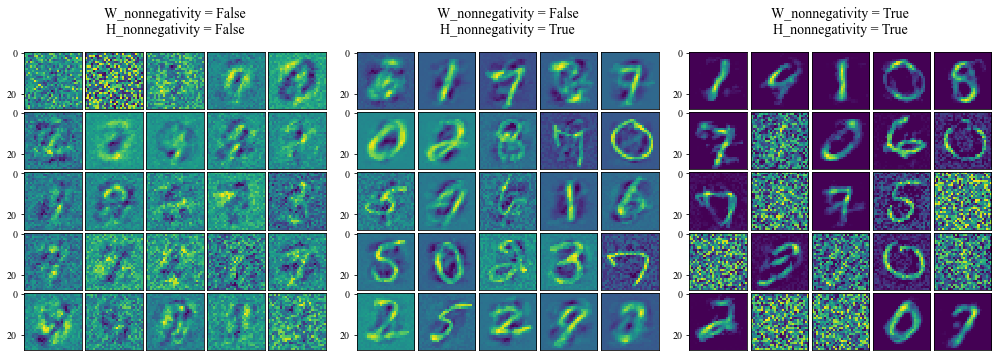

In [13]:
idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 10
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    


label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex1.pdf")



In [14]:
# MF and PCA on MNIST

idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 100
W_list = []
H_list = []

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X_train)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "MNIST_PCA_NMF_ex1.pdf")



NameError: name 'X_train' is not defined

In [15]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [16]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

  1%|          | 1/100 [00:00<00:20,  4.88it/s]

iteration 0, reconstruction error 12275.695861


 11%|█         | 11/100 [00:02<00:20,  4.45it/s]

iteration 10, reconstruction error 4223.082258


 22%|██▏       | 22/100 [00:04<00:14,  5.54it/s]

iteration 20, reconstruction error 3505.598332


 32%|███▏      | 32/100 [00:06<00:11,  5.91it/s]

iteration 30, reconstruction error 3152.450244


 42%|████▏     | 42/100 [00:08<00:09,  6.41it/s]

iteration 40, reconstruction error 2950.612850


 52%|█████▏    | 52/100 [00:09<00:07,  6.37it/s]

iteration 50, reconstruction error 2826.767948


 62%|██████▏   | 62/100 [00:11<00:06,  6.24it/s]

iteration 60, reconstruction error 2749.983058


 72%|███████▏  | 72/100 [00:12<00:04,  6.68it/s]

iteration 70, reconstruction error 2699.648016


 82%|████████▏ | 82/100 [00:14<00:02,  6.50it/s]

iteration 80, reconstruction error 2663.213878


 92%|█████████▏| 92/100 [00:16<00:01,  6.43it/s]

iteration 90, reconstruction error 2633.995927


  2%|▏         | 2/100 [00:00<00:15,  6.23it/s]

iteration 0, reconstruction error 7512.290791


 11%|█         | 11/100 [00:01<00:14,  6.31it/s]

iteration 10, reconstruction error 4343.507036


 22%|██▏       | 22/100 [00:03<00:14,  5.25it/s]

iteration 20, reconstruction error 3201.943159


 32%|███▏      | 32/100 [00:05<00:11,  5.78it/s]

iteration 30, reconstruction error 2627.831468


 42%|████▏     | 42/100 [00:07<00:11,  5.05it/s]

iteration 40, reconstruction error 2421.873205


 52%|█████▏    | 52/100 [00:09<00:08,  5.55it/s]

iteration 50, reconstruction error 2360.342841


 62%|██████▏   | 62/100 [00:11<00:07,  4.85it/s]

iteration 60, reconstruction error 2328.206030


 71%|███████   | 71/100 [00:13<00:06,  4.71it/s]

iteration 70, reconstruction error 2306.153129


 81%|████████  | 81/100 [00:15<00:03,  5.20it/s]

iteration 80, reconstruction error 2288.781924


 92%|█████████▏| 92/100 [00:17<00:01,  5.55it/s]

iteration 90, reconstruction error 2274.385226


  2%|▏         | 2/100 [00:00<00:17,  5.74it/s]

iteration 0, reconstruction error 7492.085550


 12%|█▏        | 12/100 [00:02<00:16,  5.49it/s]

iteration 10, reconstruction error 4596.226775


 21%|██        | 21/100 [00:03<00:14,  5.35it/s]

iteration 20, reconstruction error 3993.057966


 32%|███▏      | 32/100 [00:06<00:12,  5.55it/s]

iteration 30, reconstruction error 3667.610464


 42%|████▏     | 42/100 [00:07<00:10,  5.61it/s]

iteration 40, reconstruction error 3506.014921


 52%|█████▏    | 52/100 [00:09<00:07,  6.12it/s]

iteration 50, reconstruction error 3452.929975


 62%|██████▏   | 62/100 [00:11<00:06,  6.23it/s]

iteration 60, reconstruction error 3416.392852


 72%|███████▏  | 72/100 [00:12<00:04,  5.88it/s]

iteration 70, reconstruction error 3373.844279


 82%|████████▏ | 82/100 [00:14<00:02,  6.01it/s]

iteration 80, reconstruction error 3359.260397


 92%|█████████▏| 92/100 [00:16<00:01,  5.78it/s]

iteration 90, reconstruction error 3353.837579


100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


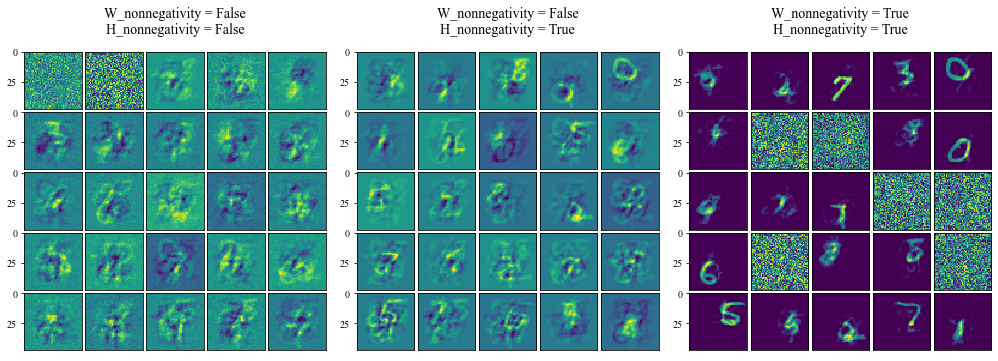

In [17]:
# Simple MNIST binary classification experiments 

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)


idx = np.random.choice(np.arange(X_train.shape[1]), 100)
X0 = X_train[idx,:].T

n_iter = 100
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex2.pdf")

  0%|          | 0/100 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, False]


  1%|          | 1/100 [00:00<00:20,  4.74it/s]

iteration 0, reconstruction error 12900.110225


 12%|█▏        | 12/100 [00:02<00:14,  6.16it/s]

iteration 10, reconstruction error 4395.578611


 22%|██▏       | 22/100 [00:03<00:12,  6.09it/s]

iteration 20, reconstruction error 3682.471443


 32%|███▏      | 32/100 [00:05<00:10,  6.29it/s]

iteration 30, reconstruction error 3370.124404


 42%|████▏     | 42/100 [00:07<00:09,  6.33it/s]

iteration 40, reconstruction error 3174.496492


 51%|█████     | 51/100 [00:08<00:08,  5.78it/s]

iteration 50, reconstruction error 3040.246245


 62%|██████▏   | 62/100 [00:10<00:07,  4.79it/s]

iteration 60, reconstruction error 2955.790563


 72%|███████▏  | 72/100 [00:12<00:04,  6.21it/s]

iteration 70, reconstruction error 2903.585656


 82%|████████▏ | 82/100 [00:14<00:03,  5.44it/s]

iteration 80, reconstruction error 2868.284262


 92%|█████████▏| 92/100 [00:16<00:01,  6.17it/s]

iteration 90, reconstruction error 2839.927273


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

!!! nonnegativitiy[i] [False, True]
iteration 0, reconstruction error 7754.918392


 12%|█▏        | 12/100 [00:01<00:13,  6.38it/s]

iteration 10, reconstruction error 4553.702274


 22%|██▏       | 22/100 [00:03<00:12,  6.14it/s]

iteration 20, reconstruction error 3185.671604


 32%|███▏      | 32/100 [00:05<00:10,  6.30it/s]

iteration 30, reconstruction error 2635.665359


 42%|████▏     | 42/100 [00:06<00:09,  6.06it/s]

iteration 40, reconstruction error 2451.555064


 52%|█████▏    | 52/100 [00:08<00:10,  4.71it/s]

iteration 50, reconstruction error 2383.331988


 62%|██████▏   | 62/100 [00:10<00:06,  6.10it/s]

iteration 60, reconstruction error 2348.790125


 72%|███████▏  | 72/100 [00:12<00:04,  5.91it/s]

iteration 70, reconstruction error 2327.000090


 82%|████████▏ | 82/100 [00:14<00:03,  5.54it/s]

iteration 80, reconstruction error 2312.094396


 91%|█████████ | 91/100 [00:15<00:01,  5.89it/s]

iteration 90, reconstruction error 2301.728986


  1%|          | 1/100 [00:00<00:19,  5.08it/s]

!!! nonnegativitiy[i] [True, True]
iteration 0, reconstruction error 7751.986286


 11%|█         | 11/100 [00:02<00:19,  4.48it/s]

iteration 10, reconstruction error 4998.320023


 22%|██▏       | 22/100 [00:04<00:13,  5.63it/s]

iteration 20, reconstruction error 4224.418169


 32%|███▏      | 32/100 [00:06<00:11,  5.89it/s]

iteration 30, reconstruction error 3795.848431


 41%|████      | 41/100 [00:07<00:10,  5.51it/s]

iteration 40, reconstruction error 3639.192148


 51%|█████     | 51/100 [00:09<00:10,  4.65it/s]

iteration 50, reconstruction error 3508.542079


 62%|██████▏   | 62/100 [00:12<00:07,  5.34it/s]

iteration 60, reconstruction error 3451.847976


 71%|███████   | 71/100 [00:14<00:06,  4.51it/s]

iteration 70, reconstruction error 3427.139004


 82%|████████▏ | 82/100 [00:16<00:03,  5.46it/s]

iteration 80, reconstruction error 3417.641385


 91%|█████████ | 91/100 [00:18<00:01,  4.62it/s]

iteration 90, reconstruction error 3413.363263


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


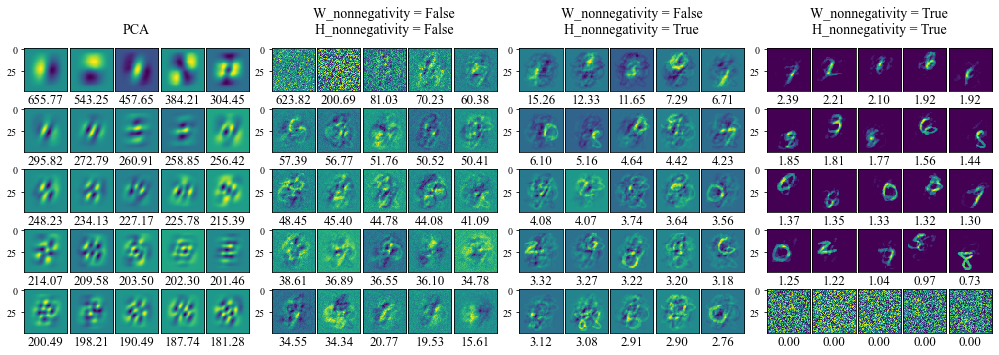

In [18]:
# MF and PCA on MNIST + padding

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)



idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X_train[idx,:].T
n_iter = 100
W_list = []
H_list = []

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X_train)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "MNIST_PCA_NMF_ex2.pdf")



## Dictionary Learing for Face datasets

In [21]:
from sklearn.datasets import fetch_olivetti_faces

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=np.random.seed(0))
n_samples, n_features = faces.shape

# global centering
#faces_centered = faces - faces.mean(axis=0)

# local centering
#faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
print("faces_centered.shape", faces.shape)

Dataset consists of 400 faces
faces_centered.shape (400, 4096)


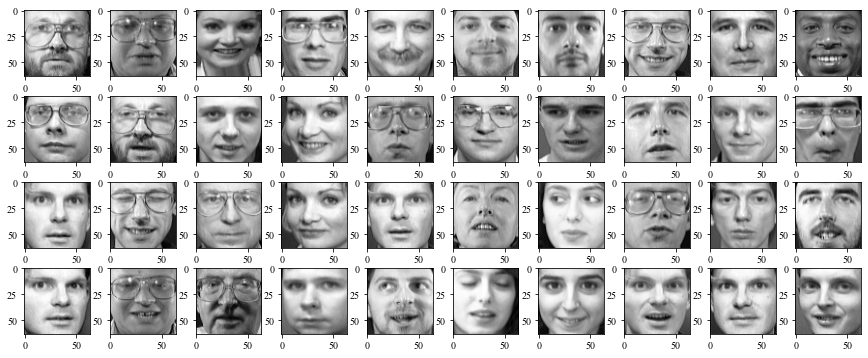

In [22]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        ax[i,j].imshow(faces[i*ncols + j].reshape(64,64), cmap="gray")
        #if i == 0:
        #    ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('Faces_ex1.pdf', bbox_inches='tight')

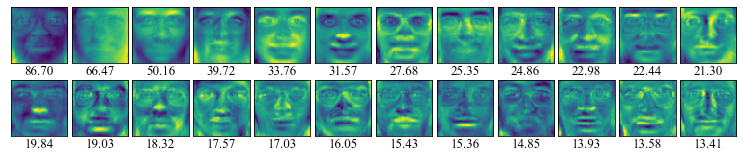

In [29]:
# PCA and dictionary images (principal components)

X0 = faces.T
pca = PCA(n_components=24)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_

display_dictionary(W, score=s, save_name = "Faces_PCA_ex1.pdf", grid_shape=[2,12])

  0%|          | 1/200 [00:05<16:35,  5.00s/it]

iteration 0, reconstruction error 25151.940635


  6%|▌         | 11/200 [01:06<20:42,  6.58s/it]

iteration 10, reconstruction error 7626.464527


 10%|█         | 21/200 [02:09<18:17,  6.13s/it]

iteration 20, reconstruction error 5829.607554


 16%|█▌        | 31/200 [03:11<17:41,  6.28s/it]

iteration 30, reconstruction error 5083.934536


 20%|██        | 41/200 [04:17<16:51,  6.36s/it]

iteration 40, reconstruction error 4648.236808


 26%|██▌       | 51/200 [05:14<14:43,  5.93s/it]

iteration 50, reconstruction error 4309.490787


 30%|███       | 61/200 [06:14<13:32,  5.84s/it]

iteration 60, reconstruction error 3943.508160


 36%|███▌      | 71/200 [07:11<12:14,  5.70s/it]

iteration 70, reconstruction error 3606.511101


 40%|████      | 81/200 [08:15<12:24,  6.26s/it]

iteration 80, reconstruction error 3386.260763


 46%|████▌     | 91/200 [09:14<10:44,  5.91s/it]

iteration 90, reconstruction error 3198.951366


 50%|█████     | 101/200 [10:14<09:47,  5.94s/it]

iteration 100, reconstruction error 3054.195399


 56%|█████▌    | 111/200 [11:12<08:34,  5.78s/it]

iteration 110, reconstruction error 2963.661888


 60%|██████    | 121/200 [12:13<07:46,  5.91s/it]

iteration 120, reconstruction error 2893.591490


 66%|██████▌   | 131/200 [13:14<06:44,  5.86s/it]

iteration 130, reconstruction error 2830.152361


 70%|███████   | 141/200 [14:22<06:40,  6.79s/it]

iteration 140, reconstruction error 2770.406586


 76%|███████▌  | 151/200 [15:26<05:17,  6.48s/it]

iteration 150, reconstruction error 2728.576729


 80%|████████  | 161/200 [16:29<04:02,  6.22s/it]

iteration 160, reconstruction error 2704.766590


 86%|████████▌ | 171/200 [17:48<03:53,  8.07s/it]

iteration 170, reconstruction error 2689.097249


 90%|█████████ | 181/200 [19:03<02:19,  7.35s/it]

iteration 180, reconstruction error 2677.184816


 96%|█████████▌| 191/200 [20:07<00:55,  6.17s/it]

iteration 190, reconstruction error 2667.300533


100%|██████████| 200/200 [20:56<00:00,  6.28s/it]


IndexError: index 25 is out of bounds for axis 0 with size 25

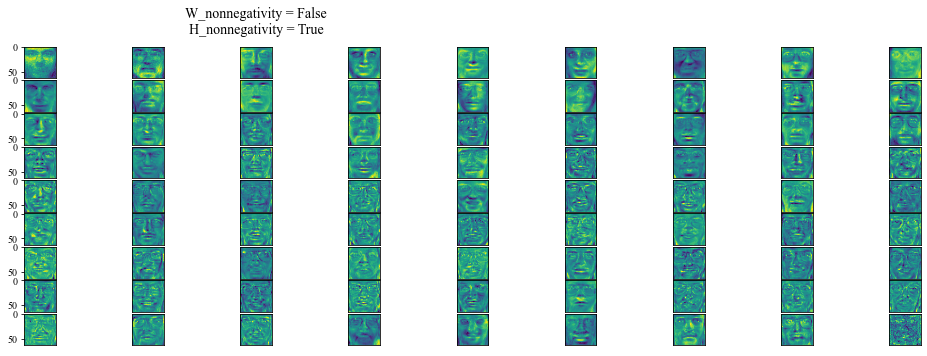

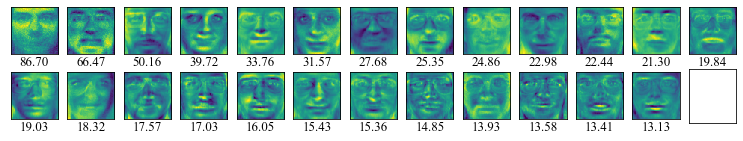

In [53]:
# Variable nonnegativity constraints 

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

n_iter = 200
W_list = []

#nonnegativitiy = [[False, False], [False, True], [True, True]]
nonnegativitiy = [[False, True]]

for i in np.arange(1): 
    W, H = ALS(X=X0, 
               n_components=81, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex1.pdf")
display_dictionary(W, score=s, save_name = "Faces_test.pdf", grid_shape=[2,13])

In [52]:
n_iter = 200
W_list = []
H_list = []

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=91, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "Faces_PCA_NMF_ex1.pdf")

  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, False]


  0%|          | 1/200 [00:07<25:34,  7.71s/it]

iteration 0, reconstruction error 188528.517834


  6%|▌         | 11/200 [01:37<31:27,  9.98s/it]

iteration 10, reconstruction error 14226.294894


 10%|█         | 21/200 [03:11<29:13,  9.79s/it]

iteration 20, reconstruction error 11716.231224


 16%|█▌        | 31/200 [04:48<26:12,  9.31s/it]

iteration 30, reconstruction error 10856.127111


 20%|██        | 41/200 [06:29<27:39, 10.44s/it]

iteration 40, reconstruction error 10352.967375


 26%|██▌       | 51/200 [08:07<23:10,  9.33s/it]

iteration 50, reconstruction error 10052.854510


 30%|███       | 61/200 [09:35<20:48,  8.98s/it]

iteration 60, reconstruction error 9798.838789


 36%|███▌      | 71/200 [11:08<19:49,  9.22s/it]

iteration 70, reconstruction error 9648.375574


 40%|████      | 81/200 [12:33<16:50,  8.49s/it]

iteration 80, reconstruction error 9468.932659


 46%|████▌     | 91/200 [13:56<14:57,  8.23s/it]

iteration 90, reconstruction error 9374.568508


 50%|█████     | 101/200 [15:19<13:31,  8.20s/it]

iteration 100, reconstruction error 9270.549715


 56%|█████▌    | 111/200 [16:42<12:14,  8.25s/it]

iteration 110, reconstruction error 9215.046102


 60%|██████    | 121/200 [18:06<10:48,  8.21s/it]

iteration 120, reconstruction error 9128.501130


 66%|██████▌   | 131/200 [19:22<08:47,  7.64s/it]

iteration 130, reconstruction error 9029.851437


 70%|███████   | 141/200 [20:42<07:54,  8.04s/it]

iteration 140, reconstruction error 8984.536801


 76%|███████▌  | 151/200 [22:04<06:43,  8.24s/it]

iteration 150, reconstruction error 8899.243520


 80%|████████  | 161/200 [23:27<05:21,  8.24s/it]

iteration 160, reconstruction error 8846.674971


 86%|████████▌ | 171/200 [24:49<03:53,  8.04s/it]

iteration 170, reconstruction error 8811.812262


 90%|█████████ | 181/200 [26:08<02:29,  7.89s/it]

iteration 180, reconstruction error 8745.344706


 96%|█████████▌| 191/200 [27:30<01:15,  8.42s/it]

iteration 190, reconstruction error 8675.244176


  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, True]


  0%|          | 1/200 [00:08<26:45,  8.07s/it]

iteration 0, reconstruction error 24920.098199


  1%|          | 2/200 [00:20<34:37, 10.49s/it]


KeyboardInterrupt: 

  0%|          | 1/200 [00:00<00:52,  3.76it/s]

iteration 0, reconstruction error 26573.351378


  6%|▌         | 12/200 [00:02<00:34,  5.40it/s]

iteration 10, reconstruction error 11140.607328


 11%|█         | 22/200 [00:04<00:31,  5.64it/s]

iteration 20, reconstruction error 10070.474084


 16%|█▌        | 32/200 [00:06<00:33,  5.05it/s]

iteration 30, reconstruction error 9545.592795


 21%|██        | 42/200 [00:07<00:28,  5.63it/s]

iteration 40, reconstruction error 9240.031090


 26%|██▌       | 52/200 [00:09<00:26,  5.55it/s]

iteration 50, reconstruction error 9102.017727


 31%|███       | 62/200 [00:11<00:24,  5.66it/s]

iteration 60, reconstruction error 9050.539432


 36%|███▌      | 72/200 [00:13<00:23,  5.46it/s]

iteration 70, reconstruction error 9046.115866


 41%|████      | 82/200 [00:15<00:21,  5.57it/s]

iteration 80, reconstruction error 9046.155498


 46%|████▌     | 92/200 [00:16<00:19,  5.53it/s]

iteration 90, reconstruction error 9015.546527


 51%|█████     | 102/200 [00:18<00:18,  5.43it/s]

iteration 100, reconstruction error 8982.335867


 56%|█████▌    | 112/200 [00:20<00:16,  5.47it/s]

iteration 110, reconstruction error 8959.198549


 61%|██████    | 122/200 [00:22<00:14,  5.47it/s]

iteration 120, reconstruction error 8942.405732


 66%|██████▌   | 132/200 [00:24<00:12,  5.41it/s]

iteration 130, reconstruction error 8929.299124


 71%|███████   | 142/200 [00:25<00:10,  5.33it/s]

iteration 140, reconstruction error 8918.982952


 76%|███████▌  | 152/200 [00:27<00:08,  5.36it/s]

iteration 150, reconstruction error 8910.677846


 80%|████████  | 161/200 [00:29<00:09,  4.03it/s]

iteration 160, reconstruction error 8903.947222


 86%|████████▌ | 171/200 [00:32<00:10,  2.88it/s]

iteration 170, reconstruction error 8898.518364


 91%|█████████ | 182/200 [00:36<00:03,  4.83it/s]

iteration 180, reconstruction error 8894.322065


 96%|█████████▌| 192/200 [00:38<00:01,  4.67it/s]

iteration 190, reconstruction error 8891.160648


  0%|          | 1/200 [00:00<00:42,  4.72it/s]

iteration 0, reconstruction error 47633.609249


  6%|▌         | 11/200 [00:03<01:04,  2.95it/s]

iteration 10, reconstruction error 11226.384114


 11%|█         | 22/200 [00:06<00:38,  4.67it/s]

iteration 20, reconstruction error 10442.746297


 16%|█▌        | 31/200 [00:08<00:38,  4.42it/s]

iteration 30, reconstruction error 10091.779157


 21%|██        | 42/200 [00:10<00:29,  5.28it/s]

iteration 40, reconstruction error 9831.221285


 26%|██▌       | 51/200 [00:12<00:30,  4.82it/s]

iteration 50, reconstruction error 9624.152379


 31%|███       | 62/200 [00:14<00:27,  4.94it/s]

iteration 60, reconstruction error 9465.725025


 36%|███▌      | 72/200 [00:16<00:24,  5.21it/s]

iteration 70, reconstruction error 9349.145346


 41%|████      | 82/200 [00:18<00:22,  5.15it/s]

iteration 80, reconstruction error 9263.695134


 46%|████▌     | 92/200 [00:20<00:19,  5.47it/s]

iteration 90, reconstruction error 9199.844981


 51%|█████     | 102/200 [00:22<00:18,  5.40it/s]

iteration 100, reconstruction error 9150.905433


 56%|█████▌    | 112/200 [00:24<00:16,  5.30it/s]

iteration 110, reconstruction error 9112.403639


 61%|██████    | 122/200 [00:26<00:14,  5.52it/s]

iteration 120, reconstruction error 9081.615653


 66%|██████▌   | 132/200 [00:27<00:12,  5.54it/s]

iteration 130, reconstruction error 9056.720237


 71%|███████   | 142/200 [00:29<00:10,  5.47it/s]

iteration 140, reconstruction error 9036.166313


 76%|███████▌  | 152/200 [00:31<00:08,  5.44it/s]

iteration 150, reconstruction error 9018.954740


 81%|████████  | 162/200 [00:33<00:07,  5.18it/s]

iteration 160, reconstruction error 9004.447860


 86%|████████▌ | 172/200 [00:35<00:05,  5.48it/s]

iteration 170, reconstruction error 8992.079002


 90%|█████████ | 181/200 [00:37<00:04,  4.56it/s]

iteration 180, reconstruction error 8981.474047


 96%|█████████▌| 192/200 [00:39<00:01,  5.28it/s]

iteration 190, reconstruction error 8972.551264


100%|██████████| 200/200 [00:40<00:00,  4.89it/s]


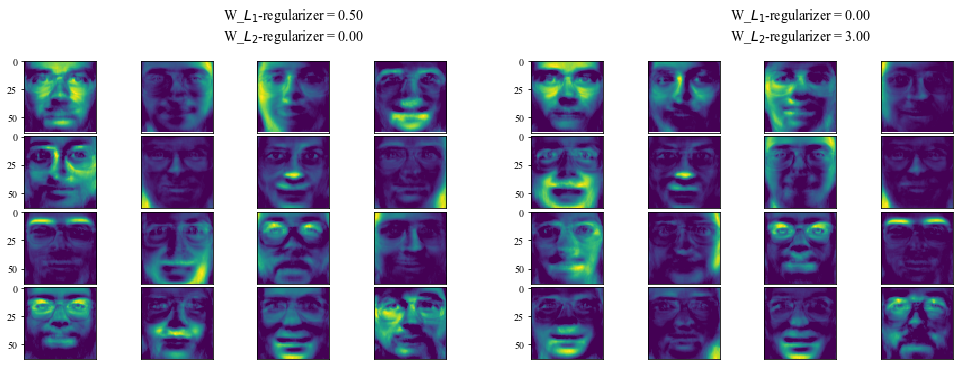

In [60]:
# Variable regularizer for W

X0 = faces.T
#print('X0.shape', X0.shape)

n_iter = 200
W_list = []

W_sparsity = [[0.5, 0], [0, 3]]

for i in np.arange(2): 
    W, H = ALS(X=X0, 
               n_components=16, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(W_sparsity)):
    label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)

display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex2.pdf")

  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, False]


  0%|          | 1/200 [00:00<01:42,  1.93it/s]

iteration 0, reconstruction error 25348.977718


  6%|▌         | 11/200 [00:04<01:21,  2.31it/s]

iteration 10, reconstruction error 9202.664922


 10%|█         | 21/200 [00:09<01:14,  2.39it/s]

iteration 20, reconstruction error 8043.444076


 16%|█▌        | 31/200 [00:13<01:10,  2.41it/s]

iteration 30, reconstruction error 7650.029706


 20%|██        | 41/200 [00:17<01:06,  2.39it/s]

iteration 40, reconstruction error 7416.450653


 26%|██▌       | 51/200 [00:21<00:59,  2.52it/s]

iteration 50, reconstruction error 7265.989759


 30%|███       | 61/200 [00:26<01:02,  2.22it/s]

iteration 60, reconstruction error 7199.513848


 36%|███▌      | 71/200 [00:30<00:52,  2.46it/s]

iteration 70, reconstruction error 7163.838592


 40%|████      | 81/200 [00:34<00:53,  2.22it/s]

iteration 80, reconstruction error 7137.444702


 46%|████▌     | 91/200 [00:39<00:46,  2.36it/s]

iteration 90, reconstruction error 7115.099093


 50%|█████     | 101/200 [00:43<00:42,  2.34it/s]

iteration 100, reconstruction error 7094.630324


 56%|█████▌    | 111/200 [00:47<00:38,  2.33it/s]

iteration 110, reconstruction error 7075.409061


 60%|██████    | 121/200 [00:52<00:37,  2.12it/s]

iteration 120, reconstruction error 7057.725988


 66%|██████▌   | 131/200 [00:57<00:31,  2.19it/s]

iteration 130, reconstruction error 7041.764187


 70%|███████   | 141/200 [01:01<00:26,  2.26it/s]

iteration 140, reconstruction error 7027.647913


 76%|███████▌  | 151/200 [01:05<00:22,  2.19it/s]

iteration 150, reconstruction error 7015.422968


 80%|████████  | 161/200 [01:10<00:18,  2.09it/s]

iteration 160, reconstruction error 7005.044197


 86%|████████▌ | 171/200 [01:15<00:14,  2.07it/s]

iteration 170, reconstruction error 6996.332197


 90%|█████████ | 181/200 [01:20<00:08,  2.13it/s]

iteration 180, reconstruction error 6989.045076


 96%|█████████▌| 191/200 [01:24<00:04,  2.19it/s]

iteration 190, reconstruction error 6982.938646


  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, True]


  0%|          | 1/200 [00:00<01:24,  2.34it/s]

iteration 0, reconstruction error 26979.491336


  6%|▌         | 11/200 [00:04<01:23,  2.27it/s]

iteration 10, reconstruction error 9582.519215


 10%|█         | 21/200 [00:08<01:19,  2.24it/s]

iteration 20, reconstruction error 8770.467024


 16%|█▌        | 31/200 [00:13<01:09,  2.42it/s]

iteration 30, reconstruction error 8285.098455


 20%|██        | 41/200 [00:17<01:09,  2.30it/s]

iteration 40, reconstruction error 8055.767413


 26%|██▌       | 51/200 [00:21<01:01,  2.41it/s]

iteration 50, reconstruction error 7967.086864


 30%|███       | 61/200 [00:25<00:58,  2.39it/s]

iteration 60, reconstruction error 7960.090314


 36%|███▌      | 71/200 [00:29<00:50,  2.53it/s]

iteration 70, reconstruction error 7914.556980


 40%|████      | 81/200 [00:33<00:48,  2.48it/s]

iteration 80, reconstruction error 7863.379268


 46%|████▌     | 91/200 [00:37<00:42,  2.56it/s]

iteration 90, reconstruction error 7816.147868


 50%|█████     | 101/200 [00:41<00:38,  2.58it/s]

iteration 100, reconstruction error 7783.438116


 56%|█████▌    | 111/200 [00:45<00:36,  2.47it/s]

iteration 110, reconstruction error 7759.986591


 60%|██████    | 121/200 [00:49<00:30,  2.58it/s]

iteration 120, reconstruction error 7739.978849


 66%|██████▌   | 131/200 [00:53<00:28,  2.46it/s]

iteration 130, reconstruction error 7722.918045


 70%|███████   | 141/200 [00:57<00:22,  2.63it/s]

iteration 140, reconstruction error 7709.133270


 76%|███████▌  | 151/200 [01:01<00:18,  2.66it/s]

iteration 150, reconstruction error 7698.140374


 80%|████████  | 161/200 [01:04<00:14,  2.63it/s]

iteration 160, reconstruction error 7689.123906


 86%|████████▌ | 171/200 [01:08<00:10,  2.69it/s]

iteration 170, reconstruction error 7681.635030


 90%|█████████ | 181/200 [01:12<00:07,  2.67it/s]

iteration 180, reconstruction error 7675.327178


 96%|█████████▌| 191/200 [01:16<00:03,  2.57it/s]

iteration 190, reconstruction error 7669.952178


  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [True, True]


  0%|          | 1/200 [00:00<01:18,  2.52it/s]

iteration 0, reconstruction error 45920.135922


  6%|▌         | 11/200 [00:04<01:16,  2.47it/s]

iteration 10, reconstruction error 9610.116408


 10%|█         | 21/200 [00:08<01:12,  2.47it/s]

iteration 20, reconstruction error 8770.508756


 16%|█▌        | 31/200 [00:12<01:08,  2.46it/s]

iteration 30, reconstruction error 8376.800857


 20%|██        | 41/200 [00:16<01:09,  2.30it/s]

iteration 40, reconstruction error 8124.073069


 26%|██▌       | 51/200 [00:20<00:59,  2.49it/s]

iteration 50, reconstruction error 7909.656656


 30%|███       | 61/200 [00:25<01:05,  2.12it/s]

iteration 60, reconstruction error 7737.353140


 36%|███▌      | 71/200 [00:29<00:52,  2.44it/s]

iteration 70, reconstruction error 7602.183167


 40%|████      | 81/200 [00:33<00:50,  2.35it/s]

iteration 80, reconstruction error 7496.534165


 46%|████▌     | 91/200 [00:37<00:44,  2.42it/s]

iteration 90, reconstruction error 7414.708460


 50%|█████     | 101/200 [00:41<00:40,  2.44it/s]

iteration 100, reconstruction error 7351.412143


 56%|█████▌    | 111/200 [00:45<00:37,  2.37it/s]

iteration 110, reconstruction error 7302.383632


 60%|██████    | 121/200 [00:49<00:32,  2.42it/s]

iteration 120, reconstruction error 7264.373713


 66%|██████▌   | 131/200 [00:53<00:28,  2.40it/s]

iteration 130, reconstruction error 7235.190572


 70%|███████   | 141/200 [00:58<00:24,  2.42it/s]

iteration 140, reconstruction error 7212.623609


 76%|███████▌  | 151/200 [01:02<00:20,  2.40it/s]

iteration 150, reconstruction error 7194.816274


 80%|████████  | 161/200 [01:06<00:19,  1.97it/s]

iteration 160, reconstruction error 7180.393847


 86%|████████▌ | 171/200 [01:11<00:12,  2.33it/s]

iteration 170, reconstruction error 7168.549585


 90%|█████████ | 181/200 [01:15<00:07,  2.38it/s]

iteration 180, reconstruction error 7158.518293


 96%|█████████▌| 191/200 [01:19<00:03,  2.29it/s]

iteration 190, reconstruction error 7149.934499


100%|██████████| 200/200 [01:23<00:00,  2.40it/s]


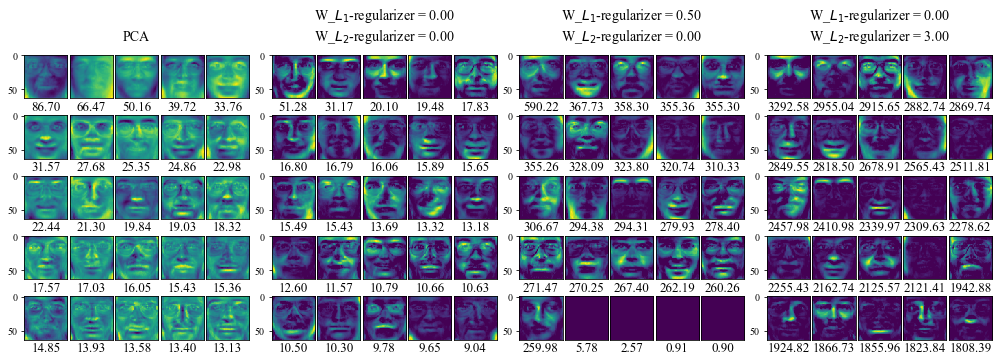

In [33]:
n_iter = 200
W_list = []
H_list = []

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

W_sparsity = ['PCA', [0, 0], [0.5, 0], [0, 3]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)


label_list = []
for i in np.arange(len(W_sparsity)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(W_sparsity)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "Faces_PCA_NMF_ex2.pdf")

## Topic modeling for 20Newsgroups dataset

In [6]:
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import entropy
import pandas as pd

In [3]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [8]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
 'comp.graphics',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'
 ]

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_labels = newsgroups_train.target
# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

# print 10 random documents
#for i in np.arange(10):
#    idx = np.random.choice(len(data_cleaned))
#    print('>>>> %i th doc \n\n %s \n\n' % (idx, data_cleaned[idx]))
    
print('len(newsgroups_labels)', len(newsgroups_labels))
print('newsgroups_labels', newsgroups_labels)

print('data_cleaned[1]', data_cleaned[1])
print('newsgroups_labels[1]', newsgroups_labels[1])

len(newsgroups_labels) 5616
newsgroups_labels [0 1 8 ... 8 1 2]
data_cleaned[1] .  Why, or how actually, can a Powerbook have a  x  pixel
    display, regardless if it is a " or ", and still keep the
     dpi resolution?  (I assume that it doesn't, and I don't 
    mean to imply they *all* have these dimensions)


.  Any info on price drops or new models (non-Duo) coming up?


newsgroups_labels[1] 1


In [9]:
# vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectorizer_BOW = CountVectorizer(stop_words=stopwords_list)
vectors_BOW = vectorizer_BOW.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
idx_to_word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

print('>>>> vectors.shape', vectors.shape)
i = 4257
print('newsgroups_labels[i]', newsgroups_labels[i])
print('>>>> data_cleaned[i]', data_cleaned[i])
# print('>>>> vectors[:,i] \n', vectors[:,i])


a = vectors[:,i].todense() 
I = np.where(a>0)

count_list = []
word_list = []

for j in np.arange(len(I[0])):
    # idx = np.random.choice(I[0])
    idx = I[0][j]
    # print('>>>> %i th coordinate <===> %s, count %i' % (idx, idx_to_word[idx], vectors[idx, i]))
    count_list.append([idx, vectors_BOW[idx, i], vectors[idx, i]])
    word_list.append(idx_to_word[idx])

d = pd.DataFrame(data=np.asarray(count_list).T, columns=word_list).T
d.columns = ['Coordinate', 'Bag-of-words', 'tf-idf']
cols = ['Coordinate', 'Bag-of-words']
d[cols] = d[cols].applymap(np.int64)

print(d)

>>>> vectors.shape (45534, 5616)
newsgroups_labels[i] 1
>>>> data_cleaned[i] Anyone know what would cause my IIcx to not turn on when I hit the keyboard
switch?  The one in the back of the machine doesn't work either...
The only way I can turn it on is to unplug the machine for a few minutes,
then plug it back in and hit the power switch in the back immediately...
Sometimes this doesn't even work for a long time...

I remember hearing about this problem a long time ago, and that a logic 
board failure was mentioned as the source of the problem...is this true?

             Coordinate  Bag-of-words    tf-idf
ago                1286             1  0.115122
back               3503             3  0.288116
board              4850             1  0.138195
cause              6355             1  0.125130
either            12551             1  0.108417
failure           14215             1  0.170555
hearing           17842             1  0.170555
hit               18278             2  0.261832
i

In [10]:
def sample_multiclass_20NEWS(list_classes=[0, 1], full_data=None, vectorizer = 'tf-idf', verbose=True):
    # get train and test set from 20NewsGroups of given categories
    # vectorizer \in ['tf-idf', 'bag-of-words']
    # documents are loaded up from the following 10 categories
    categories = [
     'comp.graphics',
     'comp.sys.mac.hardware',
     'misc.forsale',
     'rec.motorcycles',
     'rec.sport.baseball',
     'sci.med',
     'sci.space',
     'talk.politics.guns',
     'talk.politics.mideast',
     'talk.religion.misc'
     ]
    
    data_dict = {}
    data_dict.update({'categories': categories})
    
    if full_data is None:
        remove = ('headers','footers','quotes')
        stopwords_list = stopwords.words('english')
        stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])  
        
        newsgroups_train_full = fetch_20newsgroups(subset='train', categories=categories, remove=remove) # raw documents
        newsgroups_train = [re.sub(r'\d+','', file) for file in newsgroups_train_full.data] # remove numbers (we are only interested in words)
        y = newsgroups_train_full.target # document class labels 
        Y = list2onehot(y.tolist(), list_classes)
       
        
        if vectorizer == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words=stopwords_list) 
        else:
            vectorizer = CountVectorizer(stop_words=stopwords_list) 
            
        X = vectorizer.fit_transform(newsgroups_train) # words x docs  # in the form of sparse matrix
        X = np.asarray(X.todense())
        print('!! X.shape', X.shape)
        idx2word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

        data_dict.update({'newsgroups_train': data_cleaned})
        data_dict.update({'newsgroups_labels': y})
        data_dict.update({'feature_matrix': vectors})
        data_dict.update({'idx2word': idx2word})
        
    else:
        X, y = full_data

    idx = [i for i in np.arange(len(y)) if y[i] in list_classes] # list of indices where the label y is in list_classes

    X01 = X[idx,:]
    Y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(Y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(Y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    data_dict.update({'X_train': X_train})
    data_dict.update({'X_test': X_test})
    data_dict.update({'y_train': y_train})
    data_dict.update({'y_test': y_test})
  
    return X_train, X_test, y_train, y_test, data_dict 

# test 
X_train, X_test, y_train, y_test, data_dict = sample_multiclass_20NEWS(list_classes=[0, 1, 2,3,4,5,6,7,8,9], 
                                                                       vectorizer = 'bag-of-words',
                                                                       full_data=None)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)
#print('y_list', onehot2list(y_test))

!! X.shape (5616, 45534)
X_train.shape (4485, 45534)
X_test.shape (1131, 45534)
y_train.shape (4485, 10)
y_test.shape (1131, 10)
y_test [[0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [11]:
idx2word = data_dict.get('idx2word')
categories = data_dict.get('categories')

In [12]:
import random 

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


def plot_topic_wordcloud(W, idx2word, num_keywords_in_topic=5, save_name=None):
        # plot the class-conditioanl PMF as wordclouds 
        # W = (p x r) (words x topic)
        # idx2words = list of words used in the vectorization of documents 
        # categories = list of class labels
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
             
        fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), subplot_kw={'xticks': [], 'yticks': []})
        for ax, i in zip(axs.flat, np.arange(W.shape[1])):
            # dist = W[:,i]/np.sum(W[:,i])

            ### Take top k keywords in each topic (top k coordinates in each column of W)
            ### to generate text data corresponding to the ith topic, and then generate its wordcloud
            list_words = []
        
            idx = np.argsort(W[:,i])
            idx = np.flip(idx)    
           
            for j in range(num_keywords_in_topic):
                list_words.append(idx2word[idx[j]])
                
            Y = " ".join(list_words)
            #stopwords = STOPWORDS
            #stopwords.update(["’", "“", "”", "000", "000 000", "https", "co", "19", "2019", "coronavirus",
            #                  "virus", "corona", "covid", "ncov", "covid19", "amp"])
            wc = WordCloud(background_color="black",
                                  relative_scaling=0,
                                  width=400,
                                  height=400).generate(Y)
            
            ax.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
                                 interpolation="bilinear")
            
            # ax.set_xlabel(categories[i], fontsize='20')
            # ax.axis("off")

        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        if save_name is not None:
            plt.savefig(save_name, bbox_inches='tight')

In [16]:
X0 = X_train.T

print('X0.shape', X0.shape)

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=1, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=True,
           compute_recons_error=True)



  0%|          | 0/1 [00:00<?, ?it/s]

X0.shape (45534, 4485)


100%|██████████| 1/1 [00:16<00:00, 16.71s/it]

iteration 0, reconstruction error 1517431.610723


In [17]:
print(W[:,0])

print('idx2word[100]', idx2word[100])

[0.27867952 0.55781791 0.38769975 ... 0.72344863 0.04735933 0.02418166]
idx2word[100] _broken_


  5%|▌         | 1/20 [00:14<04:40, 14.75s/it]

iteration 0, reconstruction error 1523831.892422


 55%|█████▌    | 11/20 [01:51<01:36, 10.74s/it]

iteration 10, reconstruction error 770238.915545


100%|██████████| 20/20 [03:14<00:00,  9.73s/it]


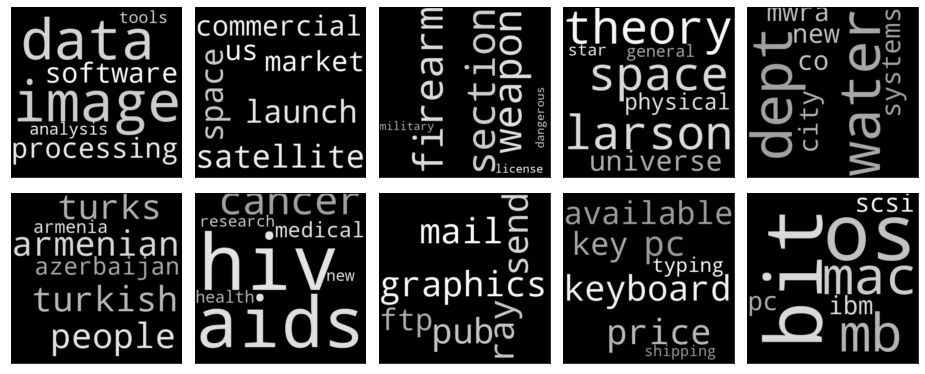

In [18]:
# Topic modeling by NMF
X0 = X_train.T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=20, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=True,
           compute_recons_error=True)

plot_topic_wordcloud(W, idx2word=idx2word, num_keywords_in_topic=7, save_name="20NEWS_topic1.pdf")


  5%|▌         | 1/20 [00:15<04:57, 15.63s/it]

iteration 0, reconstruction error 7360953.386730


 55%|█████▌    | 11/20 [01:50<01:32, 10.31s/it]

iteration 10, reconstruction error 1564821.704512


100%|██████████| 20/20 [03:10<00:00,  9.52s/it]


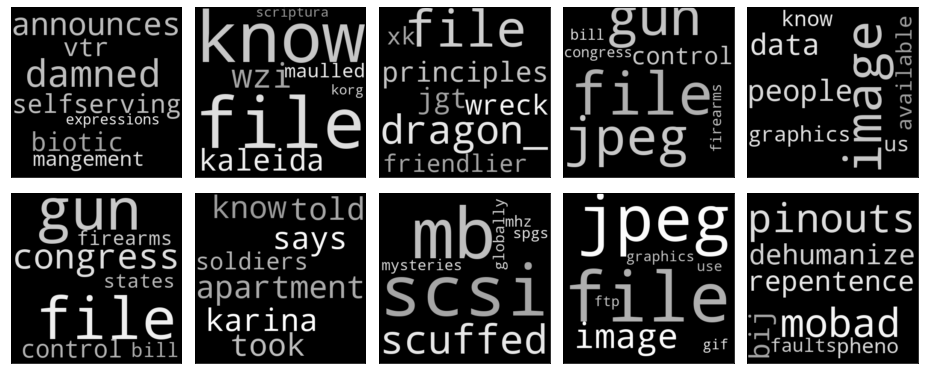

In [19]:
# Topic modeling by NMF
X0 = X_train.T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=20, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=False,
           compute_recons_error=True)


plot_topic_wordcloud(W, idx2word=idx2word, num_keywords_in_topic=7, save_name="20NEWS_topic2.pdf")